**1. Install & imports**

In [1]:
!pip install -q nltk scikit-learn wordcloud sastrawi matplotlib seaborn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 14.0 MB/s eta 0:00:00


In [6]:
import os
import re
import string
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
    classification_report
)

from wordcloud import WordCloud
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Optional Indonesian stemmer (Sastrawi) for better Indo preprocessing
try:
    from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
    sastrawi_factory = StemmerFactory()
    sastrawi_stemmer = sastrawi_factory.create_stemmer()
except Exception:
    sastrawi_stemmer = None

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


**2. Load dataset**

In [7]:
PATH = "/content/labeled_data.csv"
df = pd.read_csv(PATH)

# Quick inspection - pick text & label columns heuristically
print("Columns found:", df.columns.tolist())
# Heuristics for text column
text_col_candidates = [c for c in df.columns if c.lower() in ('text','tweet','content','message','comment','utterance','sentence')]
if not text_col_candidates:
    # fallback: choose first object/string column
    obj_cols = [c for c in df.columns if df[c].dtype == object]
    text_col = obj_cols[0] if obj_cols else df.columns[0]
else:
    text_col = text_col_candidates[0]

# Heuristics for label column
label_col_candidates = [c for c in df.columns if c.lower() in ('label','标签','target','class','hate','hate_label','is_hate','label_hate')]
if not label_col_candidates:
    # fallback: choose numeric column with only 0/1 values
    num_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number)]
    label_col = None
    for c in num_cols:
        uniq = set(df[c].dropna().unique())
        if uniq.issubset({0,1}) or uniq.issubset({0.0,1.0}):
            label_col = c
            break
    if label_col is None:
        # fallback: last column
        label_col = df.columns[-1]
else:
    label_col = label_col_candidates[0]

print("Using text column:", text_col)
print("Using label column:", label_col)

# Ensure labels are 0 or 1 (attempt to convert if needed)
df = df[[text_col, label_col]].rename(columns={text_col: "text", label_col: "label"})
df['label'] = df['label'].astype(int)
df = df.dropna(subset=['text','label']).reset_index(drop=True)
print("Dataset shape after cleanup:", df.shape)
display(df.head())

Columns found: ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet']
Using text column: tweet
Using label column: class
Dataset shape after cleanup: (24783, 2)


,text,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


**3. Preprocessing functions**

In [8]:
eng_stop = set(stopwords.words('english'))
# small Indonesian stopwords (not exhaustive) — add if dataset is Indo
ind_stop = {
    'yang','dan','di','ke','dari','ini','itu','untuk','adalah','juga','dengan','pada','saat',
    'atau','kamu','saya','kami','kalian','dia','itu','apa','mengapa','bagaimana','oleh','sebagai',
    'serta','agar','lebih','tersebut','karena','tanpa','dalam','satu','dua','jika','namun','oleh'
}
STOPWORDS = eng_stop.union(ind_stop)

lemmatizer = WordNetLemmatizer()

def preprocess_text(text, do_lemmatize=True, do_stemming_ind=False):
    # 1. Lowercase
    text = str(text).lower()
    # 2. Remove URLs, mentions, hashtags (common in social media)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#\w+', '', text)
    # 3. Remove punctuation and digits
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r'\d+', ' ', text)
    # 4. Tokenize
    tokens = word_tokenize(text)
    # 5. Remove stopwords and short tokens
    tokens = [t for t in tokens if t not in STOPWORDS and len(t) > 1]
    # 6. Lemmatize (English) and optionally Indonesian stemming
    if do_lemmatize:
        tokens = [lemmatizer.lemmatize(t) for t in tokens]
    if do_stemming_ind and sastrawi_stemmer:
        tokens = [sastrawi_stemmer.stem(t) for t in tokens]
    return " ".join(tokens)

# Quick test
print(preprocess_text("This is an Example! Visit https://example.com #hashtag @user 123"))

example visit


**4. Apply preprocessing**

In [9]:
df['text_clean'] = df['text'].apply(lambda x: preprocess_text(x, do_lemmatize=True, do_stemming_ind=False))
display(df[['text','text_clean']].head(6))

,text,text_clean
0,!!! RT @mayasolovely: As a woman you shouldn't...,rt woman complain cleaning house amp man alway...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,rt boy dat cold tyga dwn bad cuffin dat hoe st...
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,rt dawg rt ever fuck bitch start cry confused ...
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,rt look like tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,rt shit hear might true might faker bitch told ya
5,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just...",shit blow claim faithful somebody still fuckin...


**5. Visualize label distribution**

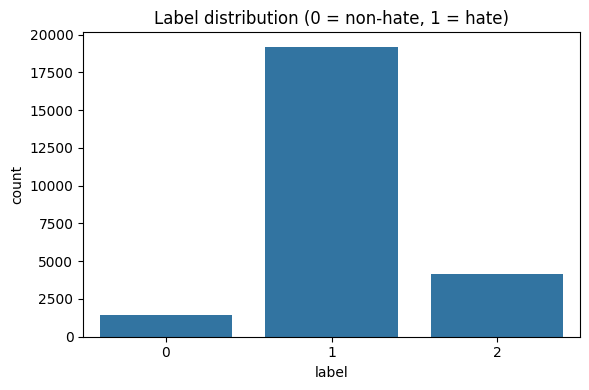

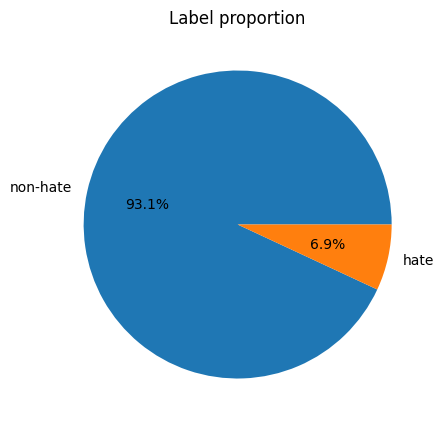

In [11]:
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.title('Label distribution (0 = non-hate, 1 = hate)')
plt.xlabel('label')
plt.ylabel('count')
plt.tight_layout()
plt.show()

# Pie chart
plt.figure(figsize=(5,5))
# Filter DataFrame to include only labels 0 and 1
df_filtered = df[df['label'].isin([0, 1])].copy()
df_filtered['label'].value_counts().plot.pie(autopct='%1.1f%%', labels=['non-hate','hate'])
plt.ylabel('')
plt.title('Label proportion')
plt.show()

**6. Word Cloud for hate speech (label == 1)**

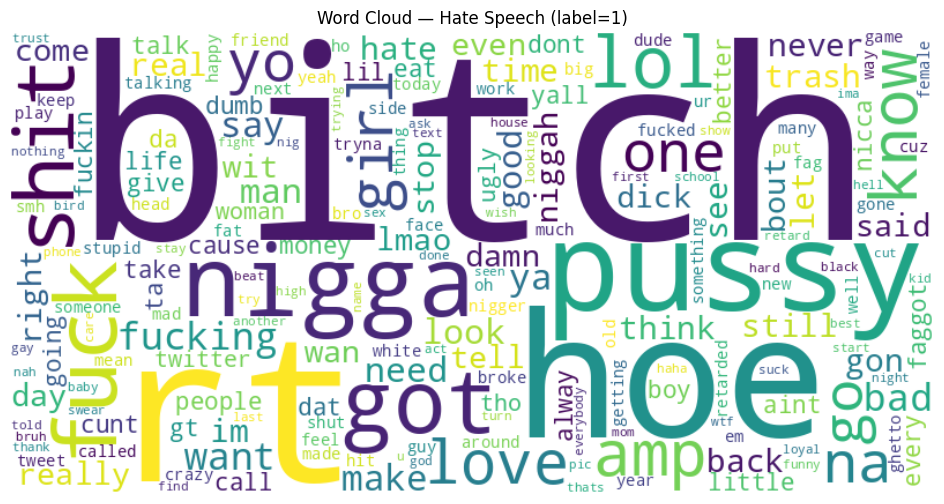

In [12]:
hate_text = " ".join(df.loc[df['label'] == 1, 'text_clean'].astype(str).tolist())
if len(hate_text.strip()) == 0:
    print("No hate-class text after preprocessing to build a word cloud.")
else:
    wc = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(hate_text)
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud — Hate Speech (label=1)')
    plt.show()

**7. Feature extraction (Bag of Words)**

In [13]:
vectorizer = CountVectorizer(max_features=10000, ngram_range=(1,2))  # uni+bi-grams
X = vectorizer.fit_transform(df['text_clean'])
y = df['label'].values
print("Feature matrix shape:", X.shape)

Feature matrix shape: (24783, 10000)


**8. Train/test split**

In [14]:
RANDOM_STATE = 42
X_train, X_test, y_train, y_test, df_train_idx, df_test_idx = train_test_split(
    X, y, df.index, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (19826, 10000) Test shape: (4957, 10000)


**9. Train Logistic Regression**

In [15]:
clf = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced', random_state=RANDOM_STATE)
clf.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='liblinear')

**10. Predictions & Evaluation**

Confusion Matrix:
 [[ 127  129   30]
 [ 168 3526  144]
 [   9   38  786]]
Accuracy: 0.8955
Precision: 0.9009
Recall: 0.8955
F1-score: 0.8972

Classification Report:

              precision    recall  f1-score   support

           0     0.4178    0.4441    0.4305       286
           1     0.9548    0.9187    0.9364      3838
           2     0.8187    0.9436    0.8767       833

    accuracy                         0.8955      4957
   macro avg     0.7304    0.7688    0.7479      4957
weighted avg     0.9009    0.8955    0.8972      4957



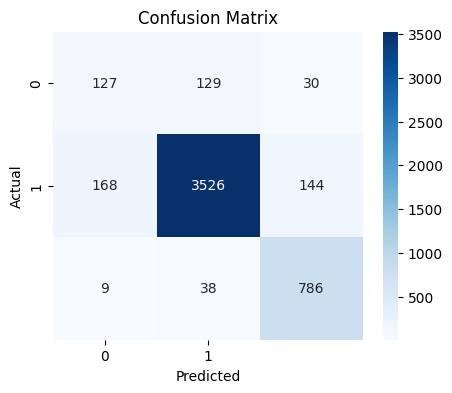

In [17]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("Confusion Matrix:\n", cm)
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

# Plot confusion matrix heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

**11. Interpret top features**

In [18]:
feature_names = vectorizer.get_feature_names_out()
coefs = clf.coef_[0]
top_pos_idx = np.argsort(coefs)[-30:][::-1]   # most positive => predictive of class 1
top_neg_idx = np.argsort(coefs)[:30]         # most negative => predictive of class 0

print("Top tokens indicating HATE (class=1):")
for i in top_pos_idx[:30]:
    print(f"{feature_names[i]} -> coef={coefs[i]:.4f}")

print("\nTop tokens indicating NON-HATE (class=0):")
for i in top_neg_idx[:30]:
    print(f"{feature_names[i]} -> coef={coefs[i]:.4f}")

Top tokens indicating HATE (class=1):
wetback -> coef=3.6681
faggot -> coef=3.4232
feminist -> coef=3.3171
spic -> coef=3.2350
fag -> coef=3.2091
queer -> coef=3.1096
nigger -> coef=3.0639
coon -> coef=2.9131
hoe tweet -> coef=2.8861
ugliest -> coef=2.7697
pussy boy -> coef=2.6816
dyke -> coef=2.6704
burn -> coef=2.6406
rt trash -> coef=2.6083
text hoe -> coef=2.5531
rt stop -> coef=2.5155
allowed -> coef=2.5062
niglet -> coef=2.4794
dyke bitch -> coef=2.4695
towel -> coef=2.4174
slavery -> coef=2.4153
chink -> coef=2.4108
slow -> coef=2.4025
hate hoe -> coef=2.3874
ima beat -> coef=2.3766
rt better -> coef=2.2869
campus -> coef=2.2673
beaner -> coef=2.2532
last year -> coef=2.2523
like fucking -> coef=2.2449

Top tokens indicating NON-HATE (class=0):
bird -> coef=-2.6495
charlie -> coef=-2.4476
start -> coef=-2.1599
rt bitch -> coef=-1.9880
th -> coef=-1.9721
lie -> coef=-1.9271
found -> coef=-1.9003
real nigga -> coef=-1.8663
jihadi -> coef=-1.8445
difference -> coef=-1.8048
weekend 

**12. Save model & vectorizer**

In [19]:
import joblib
os.makedirs("artifacts", exist_ok=True)
joblib.dump(clf, "artifacts/logreg_bow_model.joblib")
joblib.dump(vectorizer, "artifacts/countvectorizer.joblib")
print("Saved model and vectorizer to artifacts/")

Saved model and vectorizer to artifacts/


**13. Inference / demo**

In [20]:
def predict_texts(texts):
    texts_clean = [preprocess_text(t, do_lemmatize=True, do_stemming_ind=False) for t in texts]
    X_new = vectorizer.transform(texts_clean)
    preds = clf.predict(X_new)
    probs = clf.predict_proba(X_new)[:,1]
    return list(zip(texts, texts_clean, preds, probs))

examples = [
    "I hate you and your kind",
    "I love this product, excellent quality!",
    "Anda sangat bodoh dan tidak berguna"
]
print(predict_texts(examples))

[('I hate you and your kind', 'hate kind', np.int64(2), np.float64(0.2808108674212391)), ('I love this product, excellent quality!', 'love product excellent quality', np.int64(2), np.float64(0.18505407326283127)), ('Anda sangat bodoh dan tidak berguna', 'anda sangat bodoh tidak berguna', np.int64(2), np.float64(0.24274748689407874))]
